In [9]:
!pip install --quiet pyspark


  DEPRECATION: pyspark is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
!pip install --quiet matplotlib


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import sys
import os

print("Python executable:", sys.executable)
print("Environment path:", os.environ.get("VIRTUAL_ENV") or os.environ.get("CONDA_PREFIX") or "Unknown")


Python executable: e:\project_viettel\venv\Scripts\python.exe
Environment path: E:\project_viettel\venv


In [2]:
os.chdir('../data/raw')

In [3]:
from pyspark.sql import SparkSession

In [54]:
from pyspark.sql.functions import col, count, countDistinct, sum

In [5]:
spark = SparkSession.builder \
    .appName("Explore Data") \
    .getOrCreate()

In [41]:
df = spark.read.csv("retail.csv", header=True, inferSchema=True)


In [7]:
df.show(5)

+----------+----------+---------+-------------+--------------------+--------+-----------+
|   orderID| orderdate|productID|  productName|          customerID|quantity|salesamount|
+----------+----------+---------+-------------+--------------------+--------+-----------+
|ORD-000001|2024-09-28|        4|       Cheese|b0ee254d-3280-480...|       3|     272.37|
|ORD-000001|2024-09-28|       49|    Mushrooms|b0ee254d-3280-480...|       5|     306.45|
|ORD-000001|2024-09-28|       97|Baking Powder|b0ee254d-3280-480...|       5|     415.95|
|ORD-000001|2024-09-28|       87|         Peas|b0ee254d-3280-480...|       2|     156.92|
|ORD-000001|2024-09-28|       88| Chili Powder|b0ee254d-3280-480...|       3|     237.69|
+----------+----------+---------+-------------+--------------------+--------+-----------+
only showing top 5 rows


In [17]:
df.printSchema()

root
 |-- orderID: string (nullable = true)
 |-- orderdate: date (nullable = true)
 |-- productID: integer (nullable = true)
 |-- productName: string (nullable = true)
 |-- customerID: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- salesamount: double (nullable = true)



In [44]:
total_rows = df.count()
print(f"Tổng số dòng: {total_rows}")

Tổng số dòng: 500000


In [45]:
from pyspark.sql.functions import col, when, count

# Đếm số lượng giá trị null trong mỗi cột
df.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in df.columns]
).show()

+-------+---------+---------+-----------+----------+--------+-----------+
|orderID|orderdate|productID|productName|customerID|quantity|salesamount|
+-------+---------+---------+-----------+----------+--------+-----------+
|      0|        0|        0|          0|         0|       0|          0|
+-------+---------+---------+-----------+----------+--------+-----------+



In [46]:
# Xem thử môi khách hàng nào có số lượng đơn hàng trung bình mỗi ngày lớn hơn 1

from pyspark.sql.functions import countDistinct

df.groupBy("customerID").agg(
    (countDistinct("orderID") / countDistinct("orderdate")).alias("avg_orders_per_day")
).where(col("avg_orders_per_day") > 1).show()


+--------------------+------------------+
|          customerID|avg_orders_per_day|
+--------------------+------------------+
|bcb65af5-1d69-45a...|1.1428571428571428|
|934f9bf2-d4c3-4ed...|            1.0625|
|655d1c16-a9ce-451...|1.0714285714285714|
|f899db24-7e1d-423...|1.0909090909090908|
|034138f9-ee96-42d...|             1.125|
|6a6a4a3b-40e1-4ae...|1.1666666666666667|
|6b093ea7-25aa-4ff...|1.0909090909090908|
|35b5428f-5480-485...|               1.1|
|324e20fe-f13e-4d1...|               1.2|
|d4e5d224-15a5-4ee...|1.0833333333333333|
|21927ccb-d7e2-472...|1.0833333333333333|
|88afd582-2672-428...|1.1666666666666667|
|7781a043-3363-47b...|1.0833333333333333|
|d6683cc9-6a47-40a...|1.0769230769230769|
|e72c3880-5338-44d...|1.0714285714285714|
|56f6b95b-c497-445...|1.0555555555555556|
|8e3f14ae-77a5-487...|               1.2|
|2fb54259-1fe2-419...|1.1111111111111112|
|bc70260d-34e1-48b...|1.0909090909090908|
|fba19a06-bddb-467...|1.0588235294117647|
+--------------------+------------

In [47]:
# Kiểm tra xem thử có đúng là mỗi đơn hàng chỉ có một khách hàng không

df.groupBy("orderID").agg(
    countDistinct("customerID").alias("distinct_customers")
).where(col("distinct_customers") > 1).show()

+-------+------------------+
|orderID|distinct_customers|
+-------+------------------+
+-------+------------------+



In [48]:
# Kiểm tra xem mỗi product có bao nhiêu tên khác nhau

df.groupBy("productID").agg(
    countDistinct("productName").alias("distinct_product_names"),
).filter(col("distinct_product_names") > 1).show()

+---------+----------------------+
|productID|distinct_product_names|
+---------+----------------------+
+---------+----------------------+



In [49]:
import matplotlib.pyplot as plt
import pandas as pd

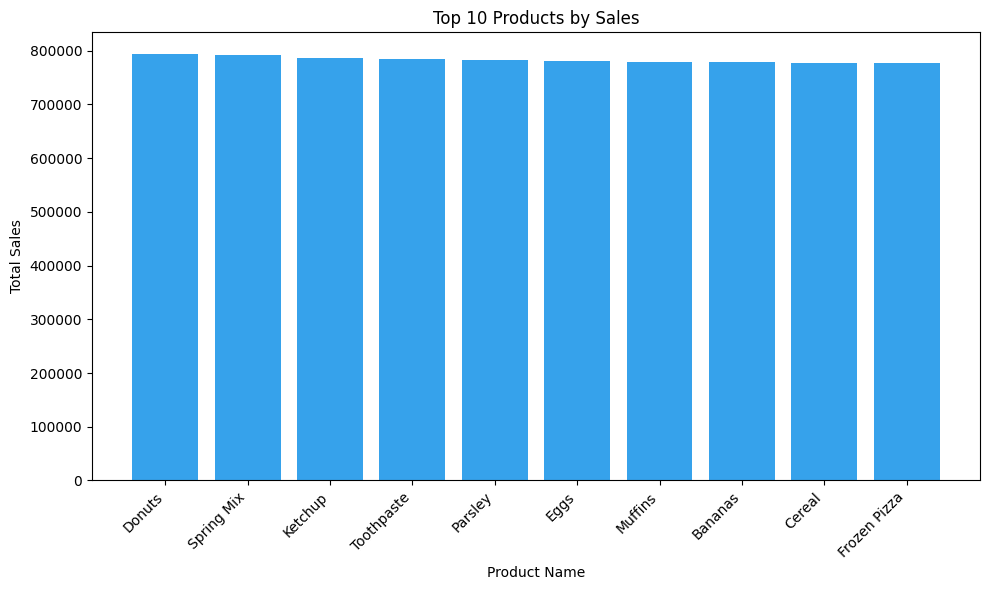

In [55]:
# Chuyển dữ liệu sang Pandas
sales_by_product_pd = df.groupBy("productName").agg(sum("salesamount").alias("total_sales")).orderBy("total_sales", ascending=False).limit(10).toPandas()

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(sales_by_product_pd['productName'], sales_by_product_pd['total_sales'], color='#36A2EB')
plt.xlabel('Product Name')
plt.ylabel('Total Sales')
plt.title('Top 10 Products by Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

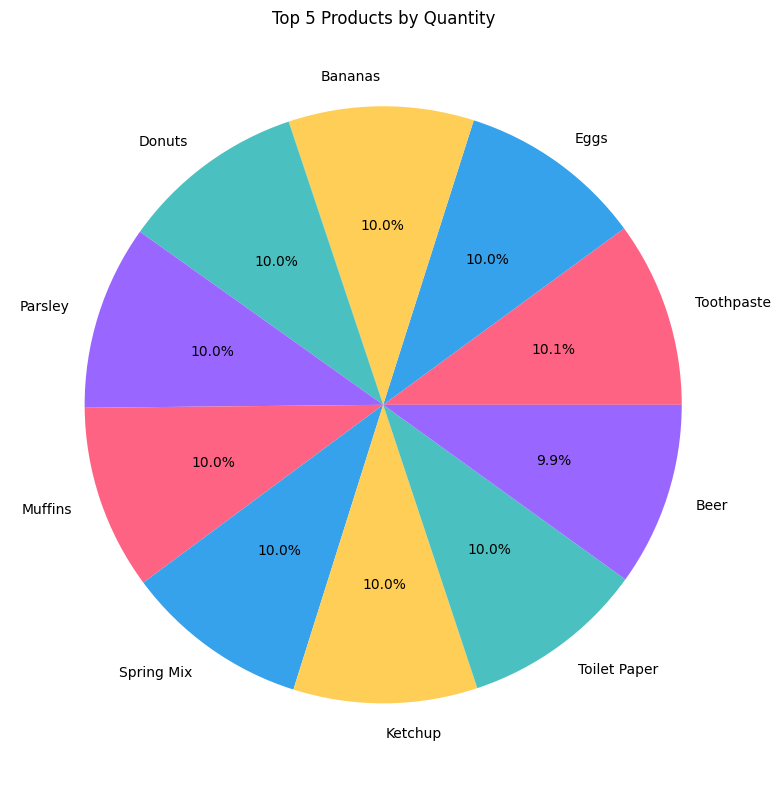

In [59]:
# Chuyển dữ liệu sang Pandas
quantity_by_product_pd = df.groupBy("productName").agg(sum("quantity").alias("total_quantity")).orderBy("total_quantity", ascending=False).limit(10).toPandas()

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 8))
plt.pie(quantity_by_product_pd['total_quantity'], labels=quantity_by_product_pd['productName'], autopct='%1.1f%%', colors=['#FF6384', '#36A2EB', '#FFCE56', '#4BC0C0', '#9966FF'])
plt.title('Top 5 Products by Quantity')
plt.tight_layout()
plt.show()

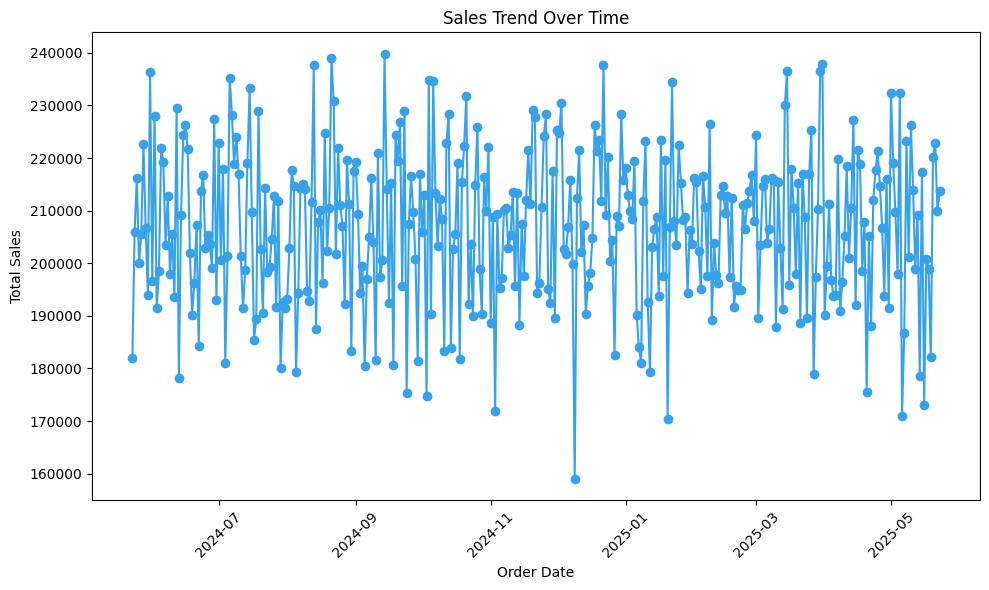

In [58]:
# Chuyển dữ liệu sang Pandas
sales_by_date_pd = df.groupBy("orderdate").agg(sum("salesamount").alias("total_sales")).orderBy("orderdate").toPandas()

# Vẽ biểu đồ đường
plt.figure(figsize=(10, 6))
plt.plot(sales_by_date_pd['orderdate'], sales_by_date_pd['total_sales'], marker='o', color='#36A2EB')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.title('Sales Trend Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()